## Case TON - Análise técnica dos dados
##### Fernando Fincatti
---

## Imports
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
from utils import*


In [2]:
df_cases = pd.read_csv("cases.csv") #importa arquivo cases
df_creds = pd.read_csv("creds.csv") #importa arquivo creds

In [3]:
df_creds.head(2)

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN


In [4]:
df_creds.columns

Index(['Unnamed: 0', 'cred_date', 'shipping_address_city',
       'shipping_address_state', 'max_machine', 'accountid'],
      dtype='object')

In [5]:
df_cases.head(2)

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_cases.columns

Index(['Unnamed: 0', 'accountid', 'date_ref', 'channelid', 'waitingtime',
       'missed', 'pesquisa_de_satisfa_o__c', 'assunto', 'Id'],
      dtype='object')

In [7]:
#filtra somente para os chamados que possuem data registrada
df_cases = df_cases.dropna(subset=['date_ref'])
df_creds = df_creds.dropna(subset=['cred_date']) 

In [8]:
#transforma dados para datetime
df_cases["date_ref"] = df_cases['date_ref'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")) 

#cria coluna ano, mês e dia
df_cases["mes"] = df_cases['date_ref'].apply(lambda x: x.month) 
df_cases["dia"] = df_cases['date_ref'].apply(lambda x: x.day) 

In [9]:
#transforma dados para datetime
df_creds["cred_date"] = df_creds['cred_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")) 

#cria coluna ano, mês e dia
df_creds["mes"] = df_creds['cred_date'].apply(lambda x: x.month) 
df_creds["dia"] = df_creds['cred_date'].apply(lambda x: x.day) 

## Questão 1.
---

In [10]:
df_cases_q1 = df_cases.copy()

In [11]:
#coluna que serve apenas para contagem de chamados
df_cases_q1["count"] = 1

#tabela com a somatória de chamados para todo o período
table_q1 = df_cases_q1[["mes", "count"]].groupby(['mes']).sum()

#tabela com a somatória de chamados para o período antes da implementação
table_q1_tendencia = df_cases_q1.loc[df_cases_q1["mes"] < 8][["mes", "count"]].groupby(['mes']).count()

In [12]:
z = np.polyfit(table_q1_tendencia.index.tolist(), table_q1_tendencia["count"].tolist(), 2)
function = np.poly1d(z)

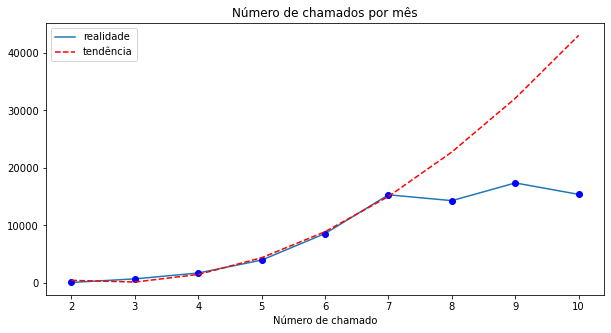

In [13]:
plt.figure(figsize=(10,5))
plt.title("Número de chamados por mês")
plt.xlabel("Número de chamado")
plt.plot(table_q1, label="realidade") #plota curva dos dados
plt.plot(table_q1, 'bo') #cria pontos
plt.plot(table_q1.index.tolist(), function(table_q1.index.tolist()),"r--", label="tendência") #realiza previsão
plt.legend()
plt.show()

Com base no gráfco acima, podemos ver que o número de chamados vinha aumentando exponencialmente, após a implementação no dia 
primeiro de agosto, o volume de chamados caiu drasticamente, quebrando completamente a tendência de crescimento do gráfico. Portanto podemos concluir que a implementação foi um sucesso!

## Questão 2.
---

In [14]:
def get_cred_date(client_id, check_list, creds):
    """
    Função responsável por pegar a data de credenciamento para determinado cliente
    Parâmetros: id do cliente (string), lista de id credenciados (list), base de credenciamento (Pandas.DataFrame)
    Retorna: Data do credenciamento se existir e "nao credenciado" caso não exista
    """
    if client_id in check_list:
        return creds.loc[creds["accountid"] == client_id]["cred_date"].tolist()[0]
    return 'nao credenciado'

In [35]:
def get_5months_before(client_id, df):
    """
    Função reposável por calcular a média de atendimentos dois meses antes do credenciamento
    Recebe: id do cliente (string), data de credenciamento (datetime), base de dados total (Pandas.Dataframe)
    """
    
    #filtra somente para o cliente desejado
    df_cliente = df.loc[df["accountid"] == client_id]
    
    #filtra para chamados meses antes
    df_cliente_before = df_cliente.loc[(df_cliente["time_distance"] <= 150) & (df_cliente["time_distance"] > 0)]
    table_before = df_cliente_before[["count", "mes_x"]].groupby(["mes_x"]).sum()
    
    #filtra para meses depois
    df_cliente_after = df_cliente.loc[(df_cliente["time_distance"] >= -30) & (df_cliente["time_distance"] <= 0)]
    table_after = df_cliente_after[["count", "mes_x"]].groupby(["mes_x"]).sum()
    
    #se não teve nenhum chamado antes
    if(table_before.shape[0] == 0):
        before = 0
    else:
        before = table_before.mean()[0]
        
    #se não teve nenhum chamado depois
    if(table_after.shape[0] == 0):
        after = 0
    else:
        after = table_after.mean()[0]
    
    return [before, after]

In [16]:
#filtra somente os cliente possíveis de serem indentificados
df_cases_q2 = df_cases.dropna(subset=["accountid"]) 
df_creds_q2 = df_creds.dropna(subset=["accountid"])

In [17]:
#junta os dois datasets, somente aqueles que estão credenciados
df_merged = pd.merge(df_cases_q2, df_creds_q2, on='accountid', how='inner')

In [18]:
#calcula distância em dias do dia de credenciamento
df_merged["time_distance"] = df_merged.apply(lambda x: (x["cred_date"] - x["date_ref"]).days, axis=1)

In [19]:
#coluna de contagem
df_merged["count"] = 1

In [36]:
lista_ids = df_merged.accountid.unique().tolist() #pega todos os id unicos
lista_media_mes_seguinte = []
lista_media_meses_anteriores = []
counter = 0 #progesso
for id_ in lista_ids:
    counter += 1
    
    response = get_5months_before(id_, df_merged) #pega chamados
    
    #armazena as médias de chamadas do mes seguinte ao cred para todos os clientes
    lista_media_mes_seguinte.append(response[id_][1])
    
    #armazena as médias de chamadas dos meses ateriores ao cred para todos os clientes
    lista_media_meses_anteriores.append(response[id_][0])   
    
    progresso = round(counter*100/len(lista_ids) , 2)
    print("{:,} | {:,} > {}%".format(counter, len(lista_ids), progresso), end = "\r")

[0, 3.0]31,429 > 3.18%
[0, 1.0]31,429 > 6.36%
[0, 1.0]31,429 > 9.55%
[0, 9.0]31,429 > 12.73%
[0, 16.0]1,429 > 15.91%
[0, 16.0]1,429 > 19.09%
[0, 5.0]31,429 > 22.27%
[0, 1.0]31,429 > 25.45%
[0, 16.0]1,429 > 28.64%
[0, 4.0] 31,429 > 31.82%
[0, 1.0] 31,429 > 35.0%%
[0, 0] | 31,429 > 38.18%
[0, 4.0] 31,429 > 41.36%
[0, 1.0] 31,429 > 44.54%
[0, 0] | 31,429 > 47.73%
[0, 0] | 31,429 > 50.91%
[0, 6.0] 31,429 > 54.09%
[0, 9.0] 31,429 > 57.27%
[0, 4.0] 31,429 > 60.45%
[0, 4.5] 31,429 > 63.64%
[0, 1.0] 31,429 > 66.82%
[4.5, 0] 31,429 > 70.0%%
[0, 6.0] 31,429 > 73.18%
[0, 1.0] 31,429 > 76.36%
[0, 1.0] 31,429 > 79.54%
[0, 0] | 31,429 > 82.73%
[0, 1.0] 31,429 > 85.91%
[0, 0] | 31,429 > 89.09%
[0, 0] | 31,429 > 92.27%
[0, 8.0] 31,429 > 95.45%
[0, 0] | 31,429 > 98.64%


In [38]:
lista_media_mes_seguinte = []
lista_media_meses_anteriores = []

for id_ in dicionario_ids:
    
    #armazena as médias de chamadas do mes seguinte ao cred para todos os clientes
    lista_media_mes_seguinte.append(dicionario_ids[id_][1])
    
    #armazena as médias de chamadas dos meses ateriores ao cred para todos os clientes
    lista_media_meses_anteriores.append(dicionario_ids[id_][0])    

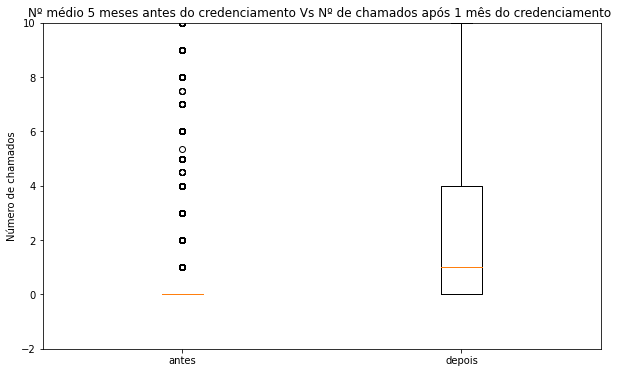

In [60]:
plt.figure(figsize=(10,6))
plt.boxplot([lista_media_meses_anteriores, lista_media_mes_seguinte], labels=['antes', 'depois'])
plt.title("Nº médio 5 meses antes do credenciamento Vs Nº de chamados após 1 mês do credenciamento ")
plt.ylim(-2, 10)
plt.ylabel("Número de chamados")
plt.show()

Como é possível observar no boxplot acima, a concetração de número médios de chamados 5 meses antes do credenciamento é muito menor quando comparado ao mês seguinte ao mesmo. Portanto, podemos conclui que o número de chamados logo após a data do credenciamento do

In [41]:
md = sum(lista_media_mes_seguinte) / len(lista_media_mes_seguinte)
md

4.912389831047759

In [42]:
md = sum(lista_media_meses_anteriores) / len(lista_media_meses_anteriores)
md

0.4235260428266887

In [ ]:
#calcula a média de chamados dos últimos 5 meses para cada cliente
#df_merged.apply(lambda x: get_5months_before(x["accountid"], df_merged), axis=1)